In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Training data folder

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='E:/Flower NLP Project/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)


Found 2494 files belonging to 5 classes.


# Subfolder image data

In [3]:
import os

train_dir = 'E:/Flower NLP Project/train'
subfolders = os.listdir(train_dir)
subfolder_counts = {}

for folder in subfolders:
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f"Number of images in {folder}: {num_images}")
        subfolder_counts[folder] = num_images



Number of images in daisy: 489
Number of images in dandelion: 559
Number of images in rose: 470
Number of images in sunflower: 473
Number of images in tulip: 503


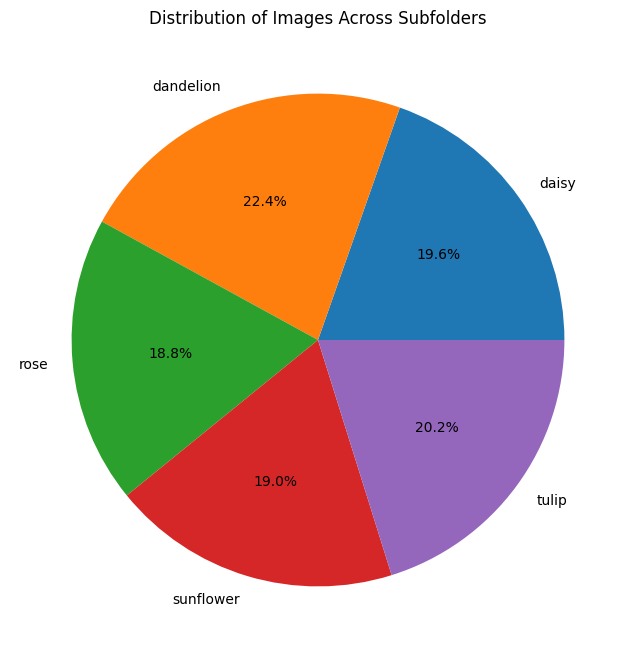

In [4]:
# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(subfolder_counts.values(), labels=subfolder_counts.keys(), autopct='%1.1f%%')
plt.title('Distribution of Images Across Subfolders')
plt.show()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import cv2
import os
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dropout, Flatten, Dense, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Input
from keras.utils import to_categorical


In [2]:
train_path = 'E:/Flower NLP Project/train'
test_path = 'E:/Flower NLP Project/test'
class_names = os.listdir(train_path)
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [3]:
X = []
y = []

for i, class_name in enumerate(class_names): 
    class_path = os.path.join(train_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = imread(image_path) 

        image = cv2.resize(image, (224, 224))
        X.append(image)
        y.append(i)
X = np.array(X)
y = np.array(y)

In [4]:
test = []

image_names = os.listdir(test_path)
image_names.sort(key = lambda x: int(re.search(r'Image_(\d+)', x).group(1))) 

for image_name in image_names:
    
    image_path = os.path.join(test_path, image_name) 
    image = imread(image_path)
    image = cv2.resize(image, (224, 224))
    test.append(image)

print("total test size :", len(os.listdir(test_path)))    

total test size : 924


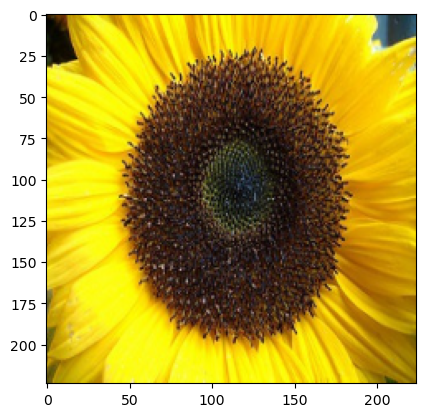

In [5]:
plt.imshow(test[1])

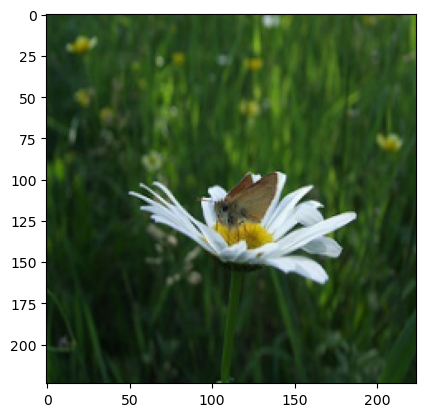

In [6]:
plt.imshow(test[923])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [8]:
# Convert target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [13]:
input_shape = 224, 224, 3
n_classes = 5

In [14]:
def resnet50(input_shape, n_classes):
    def identity_block(input_tensor, filters):
        """Identity block"""
        filters1, filters2, filters3 = filters

        x = Conv2D(filters1, (1, 1))(input_tensor)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters2, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters3, (1, 1))(x)
        x = BatchNormalization()(x)

        x = Add()([x, input_tensor])
        x = Activation('relu')(x)

        return x

    def convolutional_block(input_tensor, filters, strides=(2, 2)):
        """Convolutional block"""
        filters1, filters2, filters3 = filters

        x = Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters2, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters3, (1, 1))(x)
        x = BatchNormalization()(x)

        shortcut = Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
        shortcut = BatchNormalization()(shortcut)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        return x

    input = Input(input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D((3, 3), strides=(2, 2), padding='same')(x)

    x = convolutional_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = convolutional_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = convolutional_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    x = convolutional_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    x = AvgPool2D((7, 7))(x)
    x = Flatten()(x)
    
    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)

    return model

model = resnet50(input_shape, n_classes)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0]

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 15)
history = model.fit(X_train, y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded))

Epoch 1/100


63/63 [==============================] - 453s 6s/step - loss: 1.7632 - accuracy: 0.4697 - val_loss: 2.6429 - val_accuracy: 0.3106
Epoch 2/100
63/63 [==============================] - 358s 6s/step - loss: 1.1378 - accuracy: 0.5744 - val_loss: 1.2243 - val_accuracy: 0.5190
Epoch 3/100
63/63 [==============================] - 362s 6s/step - loss: 1.0717 - accuracy: 0.6105 - val_loss: 1.1607 - val_accuracy: 0.5311
Epoch 4/100
63/63 [==============================] - 358s 6s/step - loss: 0.9481 - accuracy: 0.6491 - val_loss: 11.4672 - val_accuracy: 0.5190
Epoch 5/100
63/63 [==============================] - 358s 6s/step - loss: 0.9301 - accuracy: 0.6727 - val_loss: 1.8335 - val_accuracy: 0.4148
Epoch 6/100
63/63 [==============================] - 356s 6s/step - loss: 0.8687 - accuracy: 0.6917 - val_loss: 1.5441 - val_accuracy: 0.4509
Epoch 7/100
63/63 [==============================] - 358s 6s/step - loss: 0.8276 - accuracy: 0.6987 - val_loss: 1.5382 - val_accuracy: 0.5030
Epo

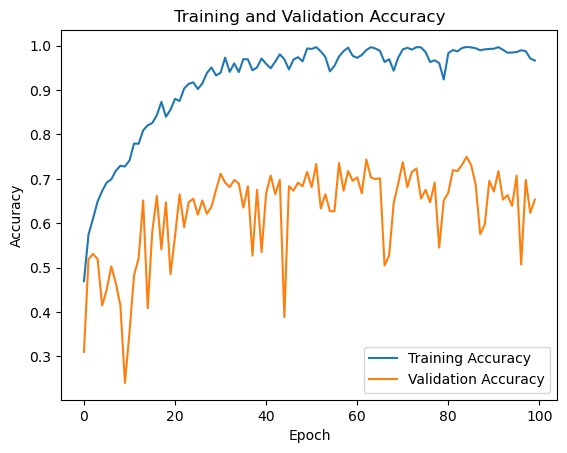

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

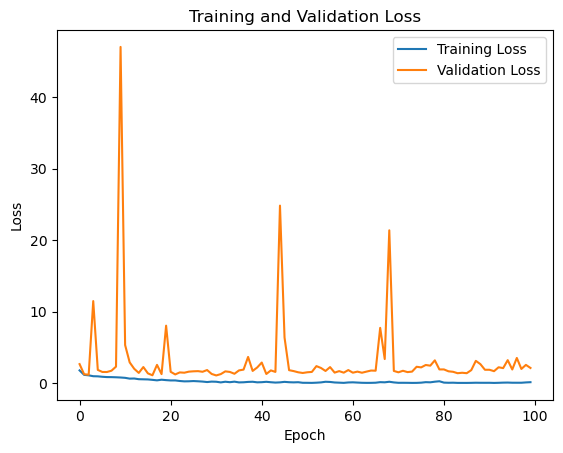

In [18]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()